This notebook shows how to do inference with yolonas and pretrained weights using the gpu. 

To add kernel I managed to add path to where venvs are stored, this solved the issue. 

Länk till YOLO NAS 2025
https://www.labellerr.com/blog/ultimate-yolo-nas-guide/ 

In [ ]:
# need to install these packages in the venv, don' know if this can be done in the notebook or must be done in the terminal
!pip install ultralytics super_gradients opencv-python


# Important Note: 
#   * Use python<=3.11 as above python version donot support super_gradients
#   * onnx may be needed to reinstall with the correct versions needed by ultralytics, for me it solved the issue with importing onnxruntime



In [1]:
from ultralytics import NAS
import matplotlib.pyplot as plt
import cv2

In [2]:
# Import Roboflow dataset example futball players
from roboflow import Roboflow

rf = Roboflow(api_key="940cpULjLlTyIVHebpd4")
project = rf.workspace("ilyes-talbi-ptwsp").project("futbol-players")
version = project.version(9)
dataset = version.download("yolov8")
print("Dataset: ", dataset.location)  # Dataset info

loading Roboflow workspace...
loading Roboflow project...
Dataset:  /home/c21/c21ion/edu/exjobb/lab/yolonas/futbol-players-9


In [2]:
# Get gpu or cpu device
import torch

DEVICE = 'cuda' if torch.cuda.is_available() else "cpu"
print("Device: ", DEVICE)

MODEL_ARCH = "yolo_nas_m" 

# you can increase this number depending on your GPU, more batch size means faster training
BATCH_SIZE = 4  
# Epoch Number
MAX_EPOCHS = 20

# base directory
HOME="/home/c21/c21ion/edu/exjobb/lab/yolonas"
EXPERIMENT_NAME="yolonas-m-model-1--20epoch"
CHECKPOINT_DIR = "/import/bulkhome/c21ion/exjobb/yolonas_test_setup/checkpoints"

Device:  cuda


In [ ]:
import sys, os
print("sys.executable:", sys.executable)
print("python:", sys.version.splitlines()[0])
print("cwd:", os.getcwd())
print("sys.path[0]:", sys.path[0])
try:
    import onnxruntime as ort, inspect, sys
    print("module file:", getattr(ort, "__file__", None))
    print("version:", getattr(ort, "__version__", None))
    import onnxruntime.capi.onnxruntime_validation as v
    print("validation attrs:", [a for a in dir(v) if "package" in a.lower() or "version" in a.lower()])
except Exception as e:
    print("validation import error:", type(e).__name__, e)

In [ ]:
from super_gradients.training import Trainer

trainer = Trainer(experiment_name=EXPERIMENT_NAME, ckpt_root_dir=CHECKPOINT_DIR)

# Dataset , Label information
dataset_params = {
    'data_dir': HOME + '/yolov8_own_data_exp', # path to dataset 
    'train_images_dir':'train/images',
    'train_labels_dir':'train/labels',
    'val_images_dir':'valid/images',
    'val_labels_dir':'valid/labels',
    'classes': ['penna'] # labels here 
}
print("Dataset params: ", dataset_params)

In [ ]:
from super_gradients.training.dataloaders.dataloaders import (
    coco_detection_yolo_format_train, coco_detection_yolo_format_val)

train_data = coco_detection_yolo_format_train(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['train_images_dir'],
        'labels_dir': dataset_params['train_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size': BATCH_SIZE,
        'num_workers': 2
    }
)

val_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['val_images_dir'],
        'labels_dir': dataset_params['val_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size': BATCH_SIZE,
        'num_workers': 2
    }
)

In [ ]:
from super_gradients.training import models

model = models.get(
    MODEL_ARCH,  # yolo_nas_m
    num_classes=len(dataset_params['classes']),
    pretrained_weights="coco" # TODO: Must remember to use weights with valid licence
)

In [7]:
# Setup training params. 
# Demonstration says that 'mixed_precision' may be set to true, 
# but demo had problems due to its gpu
from super_gradients.training.losses import PPYoloELoss
from super_gradients.training.metrics import DetectionMetrics_050
from super_gradients.training.models.detection_models.pp_yolo_e import PPYoloEPostPredictionCallback

train_params = {
    'silent_mode': False,
    "average_best_models":True,
    "warmup_mode": "linear_epoch_step",
    "warmup_initial_lr": 1e-6,
    "lr_warmup_epochs": 3,
    "initial_lr": 5e-4,
    "lr_mode": "cosine",
    "cosine_final_lr_ratio": 0.1,

    "optimizer": "Adam",
    "optimizer_params": {"weight_decay": 0.0001},
    "zero_weight_decay_on_bias_and_bn": True,
    "ema": True,
    "ema_params": {"decay": 0.9, "decay_type": "threshold"},
    "max_epochs": MAX_EPOCHS,
    "mixed_precision":  False , # TRUE BY DEFAULT , depending to GPU setting this to True might cause nan value problem in metrics
    "loss": PPYoloELoss(
        use_static_assigner=False,
        num_classes=len(dataset_params['classes']),
        reg_max=16
    ),
    "valid_metrics_list": [
        DetectionMetrics_050(
            score_thres=0.1,
            top_k_predictions=300,
            num_cls=len(dataset_params['classes']),
            normalize_targets=True,
            post_prediction_callback=PPYoloEPostPredictionCallback(
                score_threshold=0.01,
                nms_top_k=1000,
                max_predictions=300,
                nms_threshold=0.7
            )
        )
    ],
    "metric_to_watch": 'mAP@0.50'
}

In [ ]:
# Train the model
import numpy

torch.serialization.add_safe_globals([
    numpy._core.multiarray._reconstruct, 
    numpy.ndarray, 
    numpy.dtype,
    numpy.dtypes.Float64DType
])

trainer.train(
    model=model,
    training_params=train_params,
    train_loader=train_data,
    valid_loader=val_data
)

In [ ]:
# Load the best model from training
from super_gradients.training import models

best_model = models.get(
    MODEL_ARCH,
    num_classes=len(dataset_params['classes']),
    checkpoint_path="/import/bulkhome/c21ion/exjobb/yolonas_test_setup/checkpoints/yolonas-m-model-1--20epoch/RUN_20251014_125240_294157/ckpt_best.pth" # Select model
).to(DEVICE)

In [ ]:
# Perform prediction
import cv2

image_path=r"/home/c21/c21ion/edu/exjobb/lab/yolonas/yolov8_own_data_exp/valid/images/20251002_095636_jpg.rf.b71a05524adabcbcd2e39d21dc2e3873.jpg"
image = cv2.imread(image_path)

# predict
model_result = best_model.predict(image, conf=0.5)

print(model_result.prediction)

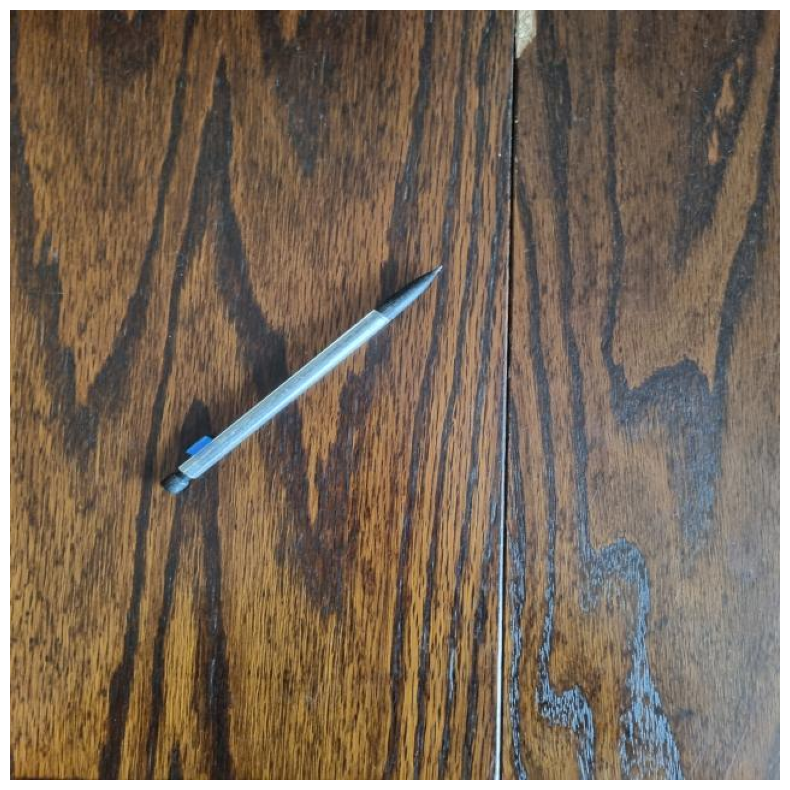

In [11]:
# Display the image with bounding boxes and labels
label_dict={0:"penna"}

import cv2
import matplotlib.pyplot as plt

# Load the image (replace with your image loading method)
image = cv2.imread(image_path)

# Bounding boxes, labels, confidence, and label dictionary
bboxes = model_result.prediction.bboxes_xyxy
confidences = model_result.prediction.confidence
labels = model_result.prediction.labels

# Draw bounding boxes and labels on the image
for i in range(len(bboxes)):
    bbox = bboxes[i]
    confidence = confidences[i]
    label = labels[i]
    
    # Coordinates of the bounding box
    x1, y1, x2, y2 = [int(coord) for coord in bbox]

    # Draw the rectangle
    cv2.rectangle(image, (x1, y1), (x2, y2), color=(0, 255, 0), thickness=2)

    # Create label text with confidence
    label_text = f"{label_dict[label]}: {confidence:.2f}"

    # Put the label text above the bounding box
    cv2.putText(image, label_text, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 
                fontScale=0.5, color=(255, 255, 255), thickness=1, lineType=cv2.LINE_AA)

# Convert BGR to RGB for displaying in matplotlib
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Display the image using matplotlib
plt.figure(figsize=(10, 10))
plt.imshow(image_rgb)
plt.axis('off')  # Turn off axis
plt.show()